In [23]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, f1_score

from google.colab import files
uploaded = files.upload()

Saving BranchPredictorDataset.csv to BranchPredictorDataset (1).csv


# Loading Dataset
A dataset containing a history of the branches stored in the following format:

   **Program Counter,  Branch History, Outcome (0/1)**


---



0x00400A, 1101, 1

0x00402C, 0110, 0


In [25]:
try:
    df = pd.read_csv("BranchPredictorDataset.csv", encoding='utf-8')
except FileNotFoundError:
    print("Error: The dataset file 'BranchPredictorDataset.csv' was not found.")
    exit()


df.columns = df.columns.str.strip().str.lower()
expected_history_col = "branch history"
expected_outcome_col = "branch outcome"

if expected_history_col not in df.columns:
    possible_cols = [col for col in df.columns if "branch" in col and "history" in col]
    if possible_cols:
        print(f"Did you mean one of these columns instead? {possible_cols}")
    else:
        print(f"Error: Column '{expected_history_col}' not found in the DataFrame.")
    exit()

if expected_outcome_col not in df.columns:
    print(f"Error: Column '{expected_outcome_col}' not found in the DataFrame.")
    exit()

df[expected_history_col] = df[expected_history_col].astype(str).apply(lambda x: [int(b) for b in x if b.isdigit()])
X = np.array(df[expected_history_col].tolist())
y = df[expected_outcome_col].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Class Distribution:
 0    1784
1     966
Name: count, dtype: int64


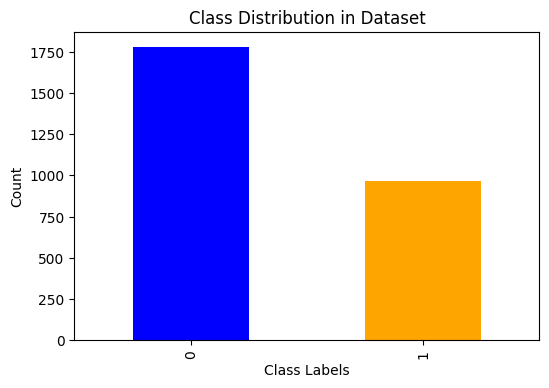

In [31]:
import matplotlib.pyplot as plt

class_counts = pd.Series(y).value_counts()
print("Class Distribution:\n", class_counts)
plt.figure(figsize=(6, 4))
class_counts.plot(kind='bar', color=['blue', 'orange'])
plt.xlabel("Class Labels")
plt.ylabel("Count")
plt.title("Class Distribution in Dataset")
plt.show()

# Goal:
Replace traditional predictors with ML models to reduce pipeline stalls.
Using two models:


*   **Decision Trees** -> Returns which branch is taken.
*   **Logistic Regression** -> Returns the probability that a branch is taken.

To integrate the model in our processor:

A simple **lookup table** can be used if the model was Decision Trees. Logistic Regression can be modeled into a **linear equation** (history * learned weight).



In [26]:
def train_and_evaluate(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)

    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Train set
    train_precision = precision_score(y_train, y_train_pred, average='weighted', zero_division=0)
    train_recall = recall_score(y_train, y_train_pred, average='weighted', zero_division=0)
    train_f1 = f1_score(y_train, y_train_pred, average='weighted', zero_division=0)

    # Test set
    test_precision = precision_score(y_test, y_test_pred, average='weighted', zero_division=0)
    test_recall = recall_score(y_test, y_test_pred, average='weighted', zero_division=0)
    test_f1 = f1_score(y_test, y_test_pred, average='weighted', zero_division=0)

    print(f"\nModel: {model.__class__.__name__}")
    print(f"Train Precision: {train_precision:.4f} | Test Precision: {test_precision:.4f}")
    print(f"Train Recall: {train_recall:.4f} | Test Recall: {test_recall:.4f}")
    print(f"Train F1 Score: {train_f1:.4f} | Test F1 Score: {test_f1:.4f}")

    # Cross-validation
    cv_scores = cross_val_score(model, X, y, cv=5, scoring="f1_weighted")
    print(f"Cross-validation F1 scores: {cv_scores}")
    print(f"Mean CV F1-score: {np.mean(cv_scores):.4f}")

In [27]:
log_reg = LogisticRegression(max_iter=1000)
train_and_evaluate(log_reg, X_train, X_test, y_train, y_test)


Model: LogisticRegression
Train Precision: 0.9474 | Test Precision: 0.9495
Train Recall: 0.9473 | Test Recall: 0.9491
Train F1 Score: 0.9469 | Test F1 Score: 0.9486
Cross-validation F1 scores: [0.89590966 0.97264315 0.96715072 0.95614363 0.90580202]
Mean CV F1-score: 0.9395


In [34]:
decision_tree = DecisionTreeClassifier(class_weight="balanced", max_depth=5, ccp_alpha=0.01)
train_and_evaluate(decision_tree, X_train, X_test, y_train, y_test)


Model: DecisionTreeClassifier
Train Precision: 0.9831 | Test Precision: 0.9767
Train Recall: 0.9827 | Test Recall: 0.9764
Train F1 Score: 0.9826 | Test F1 Score: 0.9762
Cross-validation F1 scores: [0.91240191 0.99088105 0.98905024 0.98538121 0.95952018]
Mean CV F1-score: 0.9674


Comparing traditional with ML

In [29]:
def saturating_counter_predictor(x):
    return [1 if sum(history) >= (len(history) / 2) else 0 for history in x]
def evaluate_saturating_counter(x, y):
    try:
        y_pred = saturating_counter_predictor(x)
        precision = precision_score(y, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y, y_pred, average='weighted', zero_division=0)

        print("\nTraditional: 2-bit Saturating Counter Predictor")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
    except Exception as e:
        print("Error evaluating saturating counter predictor:", e)

evaluate_saturating_counter(X_test, y_test)


Traditional: 2-bit Saturating Counter Predictor
Precision: 0.5248
Recall: 0.6473
F1 Score: 0.5194


In [32]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred_tree = decision_tree.predict(X_test)


conf_matrix = confusion_matrix(y_test, y_pred_tree)
print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", classification_report(y_test, y_pred_tree))


Confusion Matrix:
 [[357   2]
 [ 11 180]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       359
           1       0.99      0.94      0.97       191

    accuracy                           0.98       550
   macro avg       0.98      0.97      0.97       550
weighted avg       0.98      0.98      0.98       550



In [33]:
print("Per-Class Performance:")
print(classification_report(y_test, y_pred_tree, digits=4))

Per-Class Performance:
              precision    recall  f1-score   support

           0     0.9701    0.9944    0.9821       359
           1     0.9890    0.9424    0.9651       191

    accuracy                         0.9764       550
   macro avg     0.9796    0.9684    0.9736       550
weighted avg     0.9767    0.9764    0.9762       550



Class Distribution:
 1    1425
0    1425
Name: count, dtype: int64


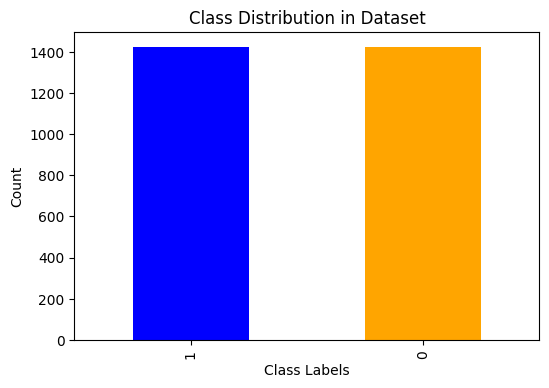

In [35]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

class_counts = pd.Series(y_resampled).value_counts()
print("Class Distribution:\n", class_counts)
plt.figure(figsize=(6, 4))
class_counts.plot(kind='bar', color=['blue', 'orange'])
plt.xlabel("Class Labels")
plt.ylabel("Count")
plt.title("Class Distribution in Dataset")
plt.show()

In [36]:
decision_tree = DecisionTreeClassifier(max_depth=5, ccp_alpha=0.01)
train_and_evaluate(decision_tree, X_resampled, X_test, y_resampled, y_test)


Model: DecisionTreeClassifier
Train Precision: 0.9768 | Test Precision: 0.9749
Train Recall: 0.9758 | Test Recall: 0.9745
Train F1 Score: 0.9758 | Test F1 Score: 0.9744
Cross-validation F1 scores: [0.91428186 0.99088105 0.98905024 0.98538121 0.89935166]
Mean CV F1-score: 0.9558
